Loading data...
Data loaded: 49923 users, 9999 events, 500000 interactions
Enhanced preprocessing...
After filtering: 49737 active users, 499682 interactions
Building weighted interaction matrix...
Interaction matrix: (49737, 9999), density: 0.000711
Enhanced feature engineering...
Creating enhanced text features...
Building TF-IDF matrices...
TF-IDF shapes: Events (9999, 2000), Users (49737, 2000)
Running enhanced SVD...
SVD factors: (49737, 100), (9999, 100)
SVD explained variance ratio: [0.00052931 0.00076064 0.00076865 0.00055556 0.00074071]
Building ground truth with data split...
Train users: 49706, Test users: 45609

ENHANCED EVALUATION
Evaluating on 45609 users with test data

Running enhanced CBF...
  Progress: 0/45609
  Progress: 100/45609
  Progress: 200/45609
  Progress: 300/45609
  Progress: 400/45609
  Progress: 500/45609
  Progress: 600/45609
  Progress: 700/45609
  Progress: 800/45609
  Progress: 900/45609
  Progress: 1000/45609
  Progress: 1100/45609
  Progress: 1200/4

/tmp/ipykernel_525103/3530394015.py:466: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


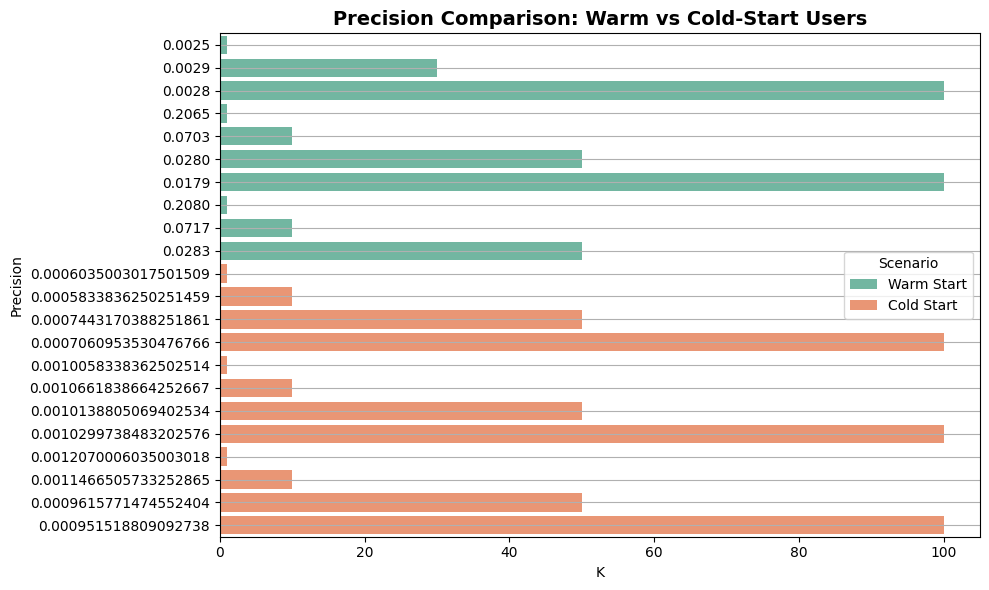

/tmp/ipykernel_525103/3530394015.py:466: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


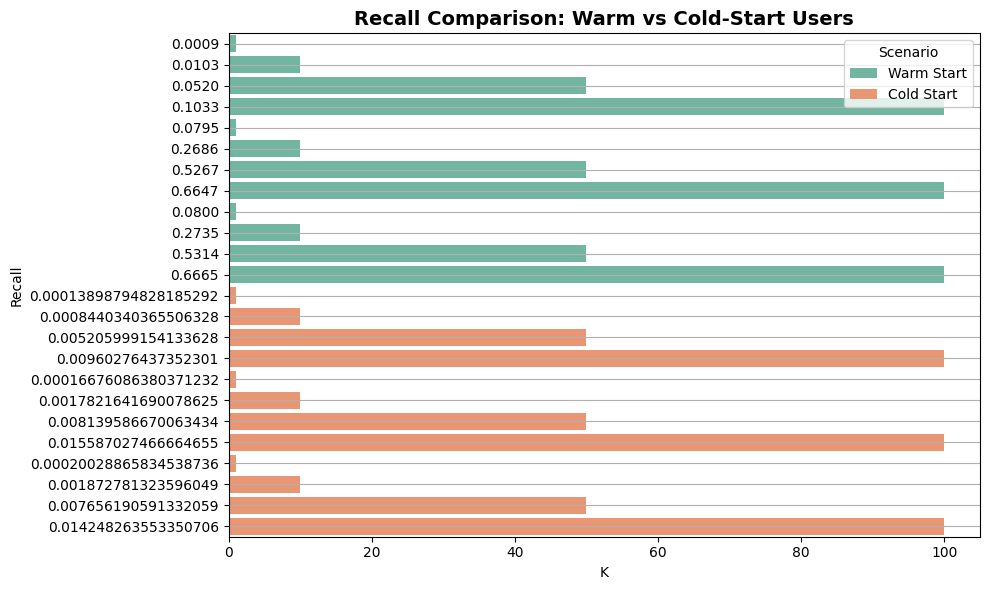

/tmp/ipykernel_525103/3530394015.py:466: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


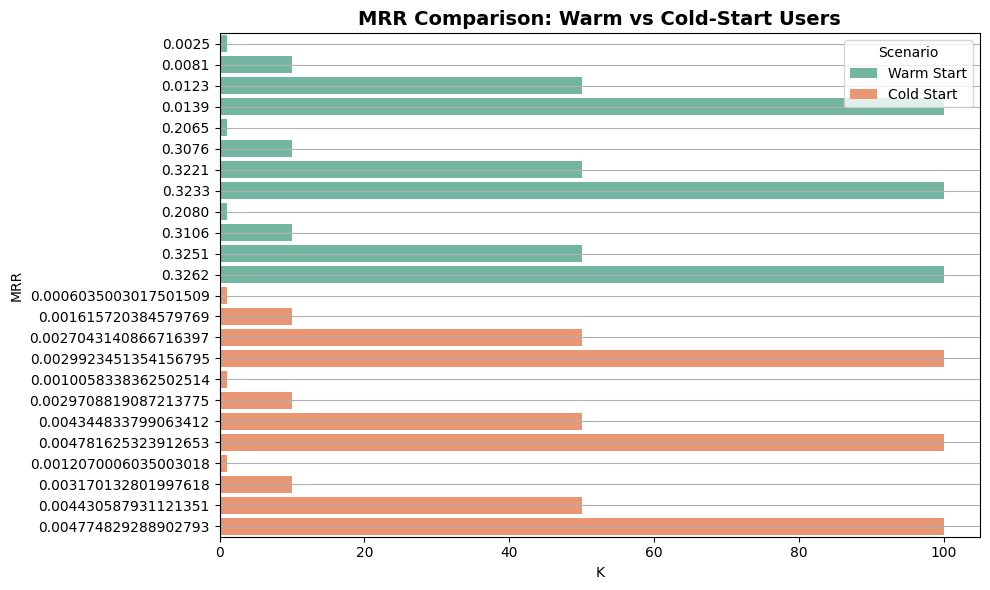

/tmp/ipykernel_525103/3530394015.py:466: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


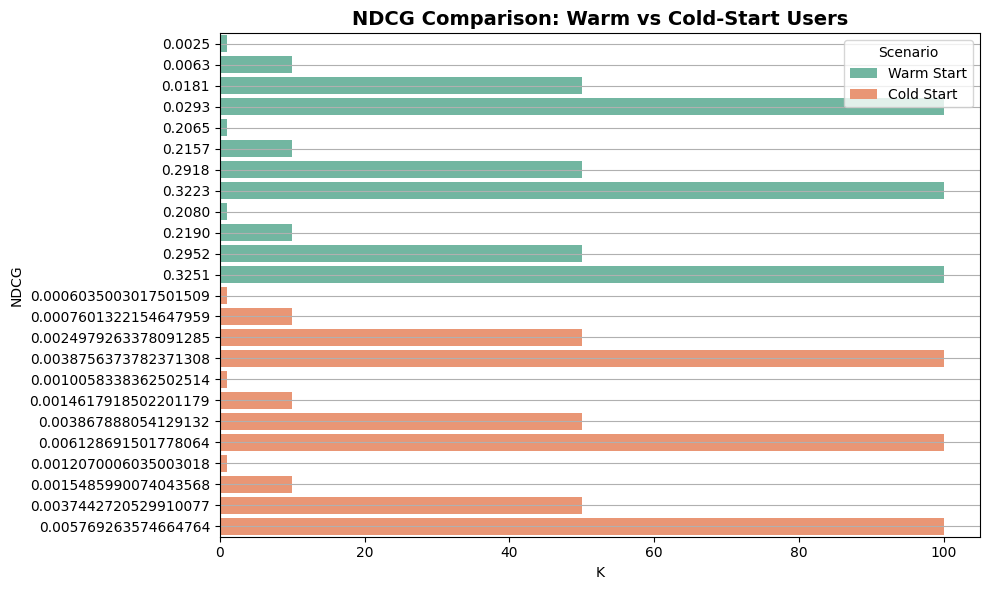

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix, lil_matrix
from collections import defaultdict
import gc

# 1. Load data with basic optimization
print("Loading data...")
users_data = pd.read_csv('/home/nkama/masters_thesis_project/thesis/fully_synthetic_data/data/users.csv')
events_data = pd.read_csv('/home/nkama/masters_thesis_project/thesis/fully_synthetic_data/data/events.csv')
interactions_data = pd.read_csv('/home/nkama/masters_thesis_project/thesis/fully_synthetic_data/data/interactions.csv')
events_data.rename(columns={'category': 'event_type'}, inplace=True)

print(f"Data loaded: {len(users_data)} users, {len(events_data)} events, {len(interactions_data)} interactions")

# 2. Enhanced data preprocessing and feature engineering
print("Enhanced preprocessing...")

# Filter interactions more carefully
valid_user_ids = set(users_data["user_id"])
valid_event_ids = set(events_data["event_id"])
filtered_interactions = interactions_data[
    interactions_data["user_id"].isin(valid_user_ids) &
    interactions_data["event_id"].isin(valid_event_ids)
].copy()

# Add interaction frequency as a signal
user_interaction_counts = filtered_interactions.groupby('user_id').size()
event_interaction_counts = filtered_interactions.groupby('event_id').size()

# Filter users/events with very few interactions (cold start problem)
min_interactions = 3
active_users = user_interaction_counts[user_interaction_counts >= min_interactions].index
popular_events = event_interaction_counts[event_interaction_counts >= min_interactions].index

# Keep original data but focus evaluation on active users
users_data = users_data[users_data['user_id'].isin(active_users)].reset_index(drop=True)
filtered_interactions = filtered_interactions[
    filtered_interactions['user_id'].isin(active_users) &
    filtered_interactions['event_id'].isin(popular_events)
].copy()

print(f"After filtering: {len(users_data)} active users, {len(filtered_interactions)} interactions")

# Encoding
user_encoder = LabelEncoder()
event_encoder = LabelEncoder()
users_data["user_idx"] = user_encoder.fit_transform(users_data["user_id"])
events_data["event_idx"] = event_encoder.fit_transform(events_data["event_id"])
filtered_interactions["user_idx"] = user_encoder.transform(filtered_interactions["user_id"])
filtered_interactions["event_idx"] = event_encoder.transform(filtered_interactions["event_id"])

num_users = len(users_data)
num_items = len(events_data)

# Sort for alignment
events_data = events_data.sort_values("event_idx").reset_index(drop=True)
users_data = users_data.sort_values("user_idx").reset_index(drop=True)

# 3. Improved interaction matrix with weighted ratings
print("Building weighted interaction matrix...")

# Create weighted interactions based on interaction type and frequency
interaction_weights = {
    0: 0.0,   # No interaction
    1: 1.0,   # Basic positive interaction
}

# Add implicit feedback signals
user_activity = filtered_interactions.groupby('user_id').size().to_dict()
event_popularity = filtered_interactions.groupby('event_id').size().to_dict()

# Build interaction matrix with weights
interaction_matrix = lil_matrix((num_users, num_items), dtype=np.float32)
for _, row in filtered_interactions.iterrows():
    base_weight = interaction_weights.get(row["interaction_label"], 0)
    if base_weight > 0:
        # Boost weight for less active users (helps with diversity)
        user_boost = 1.0 + 1.0 / max(user_activity.get(row["user_id"], 1), 1)
        # Slight penalty for very popular items (reduces popularity bias)
        popularity_penalty = 1.0 / (1.0 + np.log(event_popularity.get(row["event_id"], 1)))
        final_weight = base_weight * user_boost * (0.5 + 0.5 * popularity_penalty)
        interaction_matrix[int(row["user_idx"]), int(row["event_idx"])] = final_weight

interaction_matrix = interaction_matrix.tocsr()
print(f"Interaction matrix: {interaction_matrix.shape}, density: {interaction_matrix.nnz / (num_users * num_items):.6f}")

# 4. Enhanced feature engineering for CBF
print("Enhanced feature engineering...")

def create_enhanced_event_features(df):
    """Create richer event features"""
    features = []

    for _, row in df.iterrows():
        # Basic features
        title_words = str(row['title']).lower().split()
        event_type = str(row['event_type']).lower()
        city = str(row['event_city']).lower()
        weather = str(row['weather_condition']).lower()

        # Enhanced features
        indoor_outdoor = "indoor" if row["event_indoor_capability"] else "outdoor"
        temp_category = "cold" if row['temperature'] < 15 else "mild" if row['temperature'] < 25 else "hot"

        # Time features
        try:
            hour = int(str(row['start_time']).split(':')[0]) if ':' in str(row['start_time']) else 12
            time_period = "morning" if hour < 12 else "afternoon" if hour < 18 else "evening"
        except:
            time_period = "unknown"

        # Combine features
        feature_text = f"{' '.join(title_words)} {event_type} {city} {weather} {indoor_outdoor} {temp_category} {time_period}"
        features.append(feature_text)

    return features

def create_enhanced_user_features(df):
    """Create richer user features"""
    features = []

    for _, row in df.iterrows():
        city = str(row['user_city']).lower()
        preference = str(row['indoor_outdoor_preference']).lower()
        age = row['age']
        interests = str(row['user_interests']).lower()
        social = str(row['social_connectedness']).lower()

        # Age categories
        age_group = "young" if age < 25 else "adult" if age < 45 else "mature" if age < 65 else "senior"

        # Combine features with repetition for importance
        feature_text = f"{city} {preference} {preference} {age_group} {interests} {interests} {social}"
        features.append(feature_text)

    return features

# Create enhanced features
print("Creating enhanced text features...")
event_features = create_enhanced_event_features(events_data)
user_features = create_enhanced_user_features(users_data)

# Better TF-IDF configuration
tfidf = TfidfVectorizer(
    max_features=2000,  # Balanced feature count
    ngram_range=(1,2),  # Include bigrams for context
    max_df=0.8,         # Remove very common terms
    min_df=2,           # Remove very rare terms
    sublinear_tf=True,  # Sublinear TF scaling
    dtype=np.float32
)

print("Building TF-IDF matrices...")
tfidf_matrix_events = tfidf.fit_transform(event_features)
tfidf_matrix_users = tfidf.transform(user_features)

print(f"TF-IDF shapes: Events {tfidf_matrix_events.shape}, Users {tfidf_matrix_users.shape}")
gc.collect()

# 5. Improved SVD with better parameters
print("Running enhanced SVD...")
svd_components = min(100, num_users-1, num_items-1)  # Increased components
svd = TruncatedSVD(n_components=svd_components, random_state=42, n_iter=10)

# Normalize interaction matrix before SVD for better performance
interaction_normalized = interaction_matrix.copy().astype(np.float32)
# Apply row normalization (user-based)
from sklearn.preprocessing import normalize
interaction_normalized = normalize(interaction_normalized, norm='l2', axis=1)

user_factors = svd.fit_transform(interaction_normalized)
item_factors = svd.components_.T

print(f"SVD factors: {user_factors.shape}, {item_factors.shape}")
print(f"SVD explained variance ratio: {svd.explained_variance_ratio_[:5]}")

# 6. Ground truth with train/test split for better evaluation
print("Building ground truth with data split...")
np.random.seed(42)

# Split interactions for each user
ground_truth_train = {}
ground_truth_test = {}

positive_interactions = filtered_interactions[filtered_interactions["interaction_label"] == 1]
for user_idx in positive_interactions['user_idx'].unique():
    user_events = positive_interactions[positive_interactions['user_idx'] == user_idx]['event_idx'].tolist()

    if len(user_events) >= 4:  # Need at least 4 interactions to split
        # Use 70% for training, 30% for testing
        n_train = max(1, int(0.7 * len(user_events)))
        np.random.shuffle(user_events)

        ground_truth_train[user_idx] = user_events[:n_train]
        ground_truth_test[user_idx] = user_events[n_train:]
    else:
        # For users with few interactions, use all for training
        ground_truth_train[user_idx] = user_events
        ground_truth_test[user_idx] = []

# Filter test set to only include users with test data
ground_truth_test = {k: v for k, v in ground_truth_test.items() if len(v) > 0}
print(f"Train users: {len(ground_truth_train)}, Test users: {len(ground_truth_test)}")

gc.collect()

# 7. Enhanced recommendation functions
def build_enhanced_user_profile(user_idx, user_events):
    """Build enhanced user profile with multiple signals"""
    user_base = tfidf_matrix_users[user_idx].toarray().flatten()

    if user_events:
        # Content-based profile from user's events
        event_profile = tfidf_matrix_events[user_events].mean(axis=0).A1

        # Weighted combination - give more weight to user's natural preferences
        profile = 0.3 * user_base + 0.7 * event_profile
    else:
        profile = user_base

    return profile

def get_enhanced_recommendations(user_idx, method='hybrid', top_k=100, alpha=0.6):
    """Enhanced recommendation with better scoring"""

    if method == 'svd':
        # SVD recommendations
        scores = (item_factors @ user_factors[user_idx]).astype(np.float32)

    elif method == 'cbf':
        # Enhanced CBF
        user_events = ground_truth_train.get(user_idx, [])
        user_profile = build_enhanced_user_profile(user_idx, user_events)
        scores = cosine_similarity([user_profile], tfidf_matrix_events).flatten().astype(np.float32)

    else:  # hybrid
        # Enhanced hybrid approach
        user_events = ground_truth_train.get(user_idx, [])
        user_profile = build_enhanced_user_profile(user_idx, user_events)

        # CBF scores
        cb_scores = cosine_similarity([user_profile], tfidf_matrix_events).flatten()

        # SVD scores
        svd_scores = item_factors @ user_factors[user_idx]

        # Better normalization using robust scaling
        cb_scores = (cb_scores - np.median(cb_scores)) / (np.percentile(cb_scores, 75) - np.percentile(cb_scores, 25) + 1e-8)
        svd_scores = (svd_scores - np.median(svd_scores)) / (np.percentile(svd_scores, 75) - np.percentile(svd_scores, 25) + 1e-8)

        # Combine with learned alpha
        scores = alpha * svd_scores + (1 - alpha) * cb_scores

    # Mask training items
    train_items = ground_truth_train.get(user_idx, [])
    scores = scores.astype(np.float32)
    scores[train_items] = -np.inf

    # Get top recommendations
    if len(scores) < top_k:
        top_k = len(scores)

    top_indices = np.argpartition(scores, -top_k)[-top_k:]
    top_indices = top_indices[np.argsort(scores[top_indices])[::-1]]

    return top_indices

# 8. Improved evaluation
def evaluate_recommendations_enhanced(predictions, ground_truth, k_values=[1, 10, 50, 100]):
    """Enhanced evaluation with better metrics"""
    results = defaultdict(dict)

    for k in k_values:
        metrics = {'recall': [], 'precision': [], 'mrr': [], 'ndcg': [], 'coverage': []}
        all_recommended = set()

        for user, true_items in ground_truth.items():
            if user not in predictions or len(true_items) == 0:
                continue

            preds = predictions[user][:k]
            true_set = set(true_items)
            pred_set = set(preds)
            hits = len(pred_set & true_set)

            # Standard metrics
            metrics['recall'].append(hits / len(true_items))
            metrics['precision'].append(hits / k if k > 0 else 0)

            # MRR
            mrr = 0
            for i, pred in enumerate(preds):
                if pred in true_set:
                    mrr = 1.0 / (i + 1)
                    break
            metrics['mrr'].append(mrr)

            # NDCG
            dcg = sum((1.0 / np.log2(i + 2) if p in true_set else 0) for i, p in enumerate(preds))
            idcg = sum(1.0 / np.log2(i + 2) for i in range(min(len(true_items), k)))
            metrics['ndcg'].append(dcg / idcg if idcg > 0 else 0)

            # Track coverage
            all_recommended.update(preds)

        # Calculate average metrics
        for metric_name, values in metrics.items():
            if metric_name != 'coverage' and values:
                results[k][metric_name.capitalize()] = np.mean(values)

        # Coverage (catalog coverage)
        results[k]['Coverage'] = len(all_recommended) / num_items if num_items > 0 else 0

    return results

# 9. Run evaluations
print("\n" + "="*60)
print("ENHANCED EVALUATION")
print("="*60)

methods = ['cbf', 'svd', 'hybrid']
eval_users = list(ground_truth_test.keys())
print(f"Evaluating on {len(eval_users)} users with test data")

results = {}
for method in methods:
    print(f"\nRunning enhanced {method.upper()}...")

    predictions = {}
    for i, user_idx in enumerate(eval_users):
        if i % 100 == 0:
            print(f"  Progress: {i}/{len(eval_users)}")

        try:
            preds = get_enhanced_recommendations(user_idx, method=method, top_k=100)
            predictions[user_idx] = preds
        except Exception as e:
            print(f"  Error for user {user_idx}: {e}")
            continue

    # Evaluate
    if predictions:
        results[method] = evaluate_recommendations_enhanced(predictions, ground_truth_test)
        print(f"  {method.upper()} completed: {len(predictions)} users")
    else:
        print(f"  {method.upper()} failed completely")
        results[method] = None

# 10. Display enhanced results
print("\n" + "="*60)
print("ENHANCED RESULTS")
print("="*60)

rows = []
for method in methods:
    if results[method] is not None:
        for k in [1, 10, 50, 100]:
            row = {
                "Model": method.upper(),
                "k": k,
                "Precision": f"{results[method][k]['Precision']:.4f}",
                "Recall": f"{results[method][k]['Recall']:.4f}",
                "MRR": f"{results[method][k]['Mrr']:.4f}",
                "NDCG": f"{results[method][k]['Ndcg']:.4f}",
                "Coverage": f"{results[method][k]['Coverage']:.4f}",
            }
            rows.append(row)

if rows:
    metrics_df = pd.DataFrame(rows)
    print(metrics_df)
    metrics_df.to_csv("baseline_metrics_results.csv", index=False)
else:
    print("No results to display")

print(f"\nEvaluation completed!")

import matplotlib.pyplot as plt
import seaborn as sns

# -------------------
# Simulate Cold-Start Users
# -------------------
print("\n" + "="*60)
print("COLD-START USER EVALUATION")
print("="*60)

# Pick 10-20% of users as cold
all_user_ids = users_data["user_id"].unique()
cold_user_ids = np.random.choice(all_user_ids, size=int(0.10 * len(all_user_ids)), replace=False)

# Cold interactions
cold_interactions = interactions_data[
    interactions_data["user_id"].isin(cold_user_ids) &
    interactions_data["event_id"].isin(events_data["event_id"])
].copy()

# Cold users
cold_users = users_data[users_data["user_id"].isin(cold_user_ids)].copy()
cold_users = cold_users.reset_index(drop=True)
cold_users["user_idx"] = np.arange(len(cold_users))

# Cold interactions with index
cold_interactions = cold_interactions.merge(cold_users[["user_id", "user_idx"]], on="user_id")
cold_interactions = cold_interactions.merge(events_data[["event_id", "event_idx"]], on="event_id")

# Build cold ground truth
cold_ground_truth = {}
positive = cold_interactions[cold_interactions["interaction_label"] == 1]
for user_idx in positive["user_idx"].unique():
    items = positive[positive["user_idx"] == user_idx]["event_idx"].tolist()
    if items:
        cold_ground_truth[user_idx] = items

print(f"Cold-start users with relevant items: {len(cold_ground_truth)}")

# Evaluate cold-start recommendations
results_cold = {}
for method in methods:
    print(f"Evaluating {method.upper()} for cold users...")
    predictions = {}
    for user_idx in cold_ground_truth:
        try:
            preds = get_enhanced_recommendations(user_idx, method=method, top_k=100)
            predictions[user_idx] = preds
        except Exception as e:
            print(f"  Error for user {user_idx} ({method}): {e}")
    results_cold[method] = evaluate_recommendations_enhanced(predictions, cold_ground_truth)

# Format results
cold_rows = []
for method in methods:
    if results_cold[method] is not None:
        for k in [1, 10, 50, 100]:
            row = {
                "Scenario": "Cold Start",
                "Model": method.upper(),
                "k": k,
                "Precision": float(results_cold[method][k].get('Precision', 0)),
                "Recall": float(results_cold[method][k].get('Recall', 0)),
                "MRR": float(results_cold[method][k].get('Mrr', 0)),
                "NDCG": float(results_cold[method][k].get('Ndcg', 0)),
                "Coverage": float(results_cold[method][k].get('Coverage', 0)),
            }
            cold_rows.append(row)

cold_df = pd.DataFrame(cold_rows)
cold_df.to_csv("cold_start_metrics_results.csv", index=False)
# -------------------
# Plot Comparison: Warm vs Cold
# -------------------
if rows:  # from warm start above
    warm_df = metrics_df.copy()
    warm_df["Scenario"] = "Warm Start"
    comparison_df = pd.concat([warm_df, cold_df], ignore_index=True)

    metrics_to_plot = ["Precision", "Recall", "MRR", "NDCG"]

    for metric in metrics_to_plot:
        plt.figure(figsize=(10, 6))
        sns.barplot(
            data=comparison_df,
            x="k", y=metric, hue="Scenario",
            ci=None, palette="Set2"
        )
        plt.title(f"{metric} Comparison: Warm vs Cold-Start Users", fontsize=14, weight="bold")
        plt.xlabel("K")
        plt.ylabel(metric)
        plt.legend(title="Scenario")
        plt.tight_layout()
        plt.grid(True, axis='y')
        plt.show()

    comparison_df.to_csv("comparison_warm_vs_cold.csv", index=False)
else:
    print("Warm-start results not found. Skipping plot.")


## Non_weather features implementation

Loading data...
Data loaded: 49923 users, 9999 events, 500000 interactions
Enhanced preprocessing...
After filtering: 49737 active users, 499682 interactions
Building weighted interaction matrix...
Interaction matrix: (49737, 9999), density: 0.000711
Enhanced feature engineering (no weather features)...
Creating enhanced text features (no weather)...
Building TF-IDF matrices...
TF-IDF shapes: Events (9999, 2000), Users (49737, 2000)
Running enhanced SVD...
SVD factors: (49737, 100), (9999, 100)
SVD explained variance ratio: [0.00052931 0.00076064 0.00076865 0.00055556 0.00074071]
Building ground truth with data split...
Train users: 49706, Test users: 45609

ENHANCED EVALUATION (NO WEATHER FEATURES)
Evaluating on 45609 users with test data

Running enhanced CBF (no weather)...
  Progress: 0/45609
  Progress: 100/45609
  Progress: 200/45609
  Progress: 300/45609
  Progress: 400/45609
  Progress: 500/45609
  Progress: 600/45609
  Progress: 700/45609
  Progress: 800/45609
  Progress: 900/

/tmp/ipykernel_525103/3619798983.py:469: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


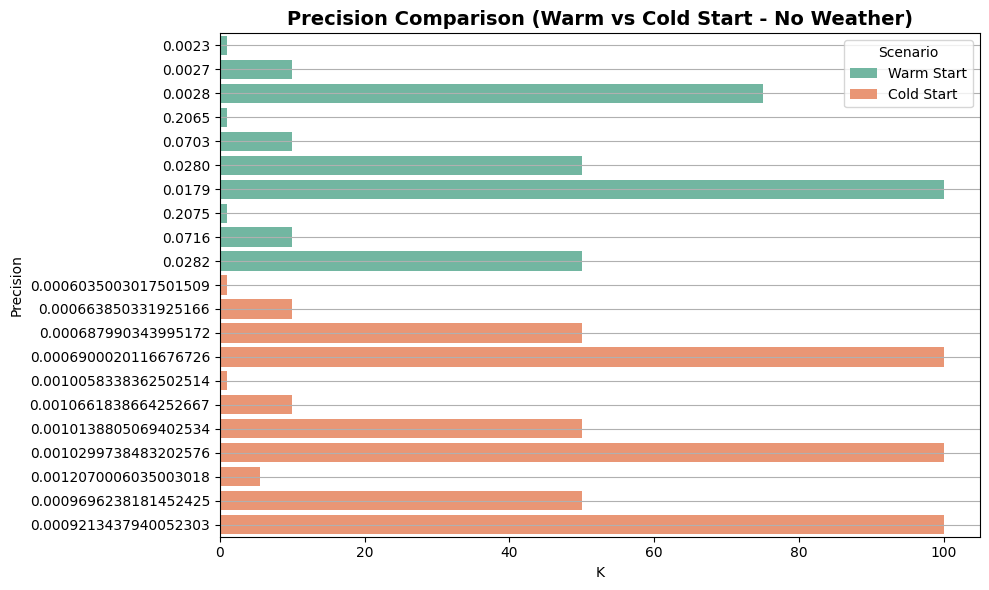

/tmp/ipykernel_525103/3619798983.py:469: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


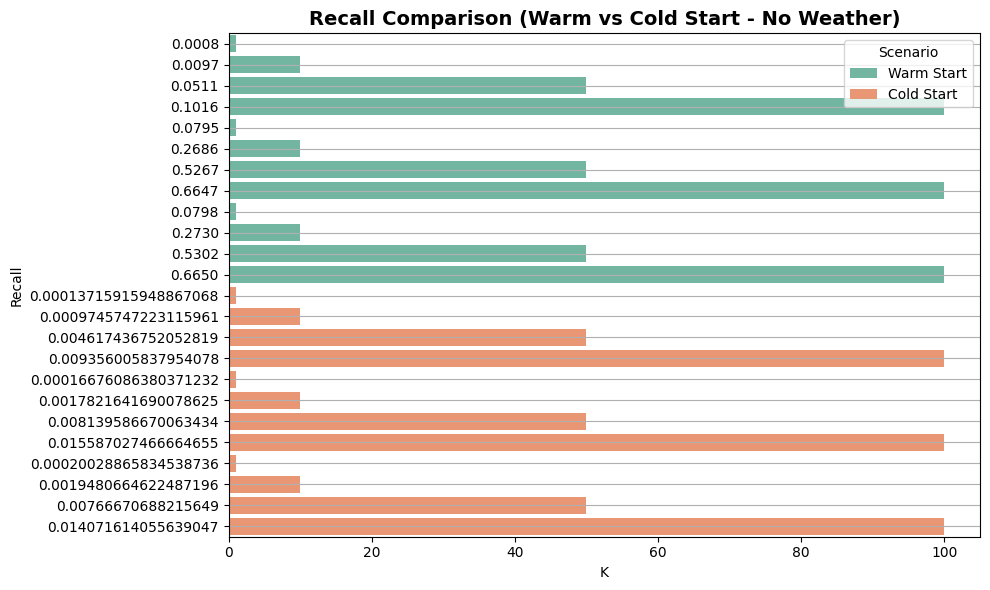

/tmp/ipykernel_525103/3619798983.py:469: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


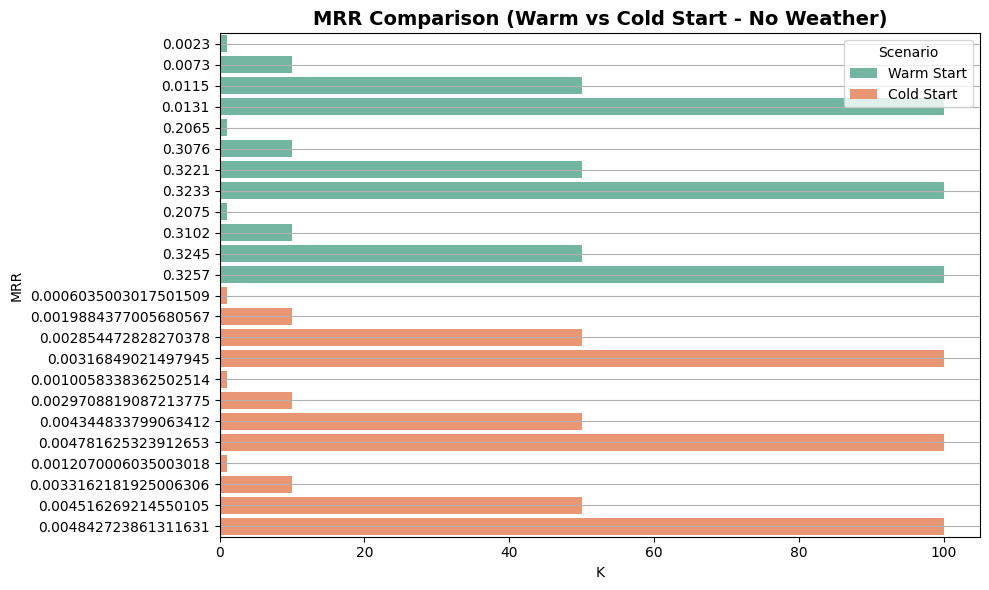

/tmp/ipykernel_525103/3619798983.py:469: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


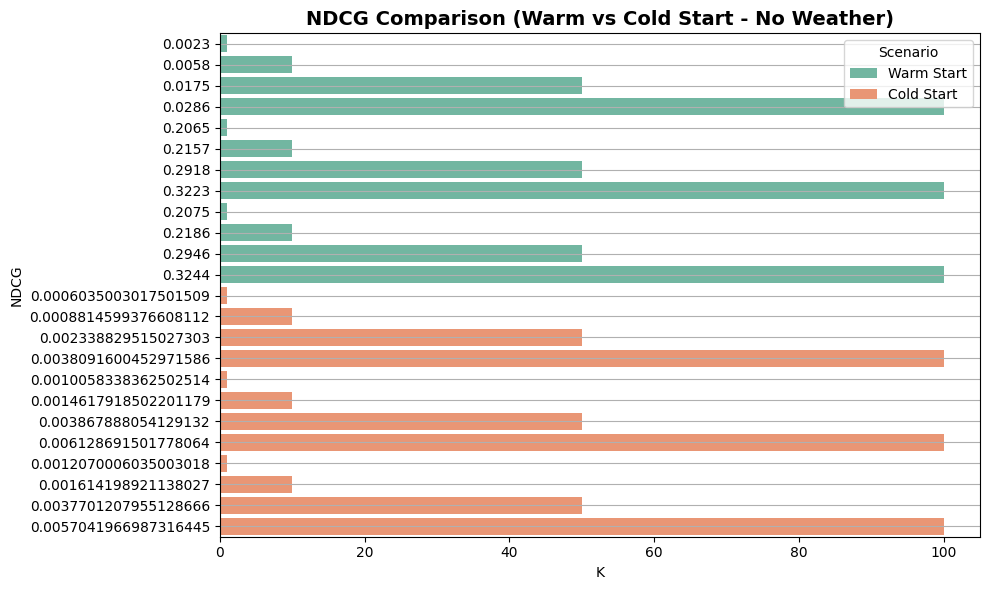

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix, lil_matrix
from collections import defaultdict
import gc

# 1. Load data with basic optimization
print("Loading data...")
users_data = pd.read_csv('/home/nkama/masters_thesis_project/thesis/fully_synthetic_data/data/users.csv')
events_data = pd.read_csv('/home/nkama/masters_thesis_project/thesis/fully_synthetic_data/data/events.csv')
interactions_data = pd.read_csv('/home/nkama/masters_thesis_project/thesis/fully_synthetic_data/data/interactions.csv')
events_data.rename(columns={'category': 'event_type'}, inplace=True)

print(f"Data loaded: {len(users_data)} users, {len(events_data)} events, {len(interactions_data)} interactions")

# 2. Enhanced data preprocessing and feature engineering
print("Enhanced preprocessing...")

# Filter interactions more carefully
valid_user_ids = set(users_data["user_id"])
valid_event_ids = set(events_data["event_id"])
filtered_interactions = interactions_data[
    interactions_data["user_id"].isin(valid_user_ids) &
    interactions_data["event_id"].isin(valid_event_ids)
].copy()

# Add interaction frequency as a signal
user_interaction_counts = filtered_interactions.groupby('user_id').size()
event_interaction_counts = filtered_interactions.groupby('event_id').size()

# Filter users/events with very few interactions (cold start problem)
min_interactions = 3
active_users = user_interaction_counts[user_interaction_counts >= min_interactions].index
popular_events = event_interaction_counts[event_interaction_counts >= min_interactions].index

# Keep original data but focus evaluation on active users
users_data = users_data[users_data['user_id'].isin(active_users)].reset_index(drop=True)
filtered_interactions = filtered_interactions[
    filtered_interactions['user_id'].isin(active_users) &
    filtered_interactions['event_id'].isin(popular_events)
].copy()

print(f"After filtering: {len(users_data)} active users, {len(filtered_interactions)} interactions")

# Encoding
user_encoder = LabelEncoder()
event_encoder = LabelEncoder()
users_data["user_idx"] = user_encoder.fit_transform(users_data["user_id"])
events_data["event_idx"] = event_encoder.fit_transform(events_data["event_id"])
filtered_interactions["user_idx"] = user_encoder.transform(filtered_interactions["user_id"])
filtered_interactions["event_idx"] = event_encoder.transform(filtered_interactions["event_id"])

num_users = len(users_data)
num_items = len(events_data)

# Sort for alignment
events_data = events_data.sort_values("event_idx").reset_index(drop=True)
users_data = users_data.sort_values("user_idx").reset_index(drop=True)

# 3. Improved interaction matrix with weighted ratings
print("Building weighted interaction matrix...")

# Create weighted interactions based on interaction type and frequency
interaction_weights = {
    0: 0.0,   # No interaction
    1: 1.0,   # Basic positive interaction
}

# Add implicit feedback signals
user_activity = filtered_interactions.groupby('user_id').size().to_dict()
event_popularity = filtered_interactions.groupby('event_id').size().to_dict()

# Build interaction matrix with weights
interaction_matrix = lil_matrix((num_users, num_items), dtype=np.float32)
for _, row in filtered_interactions.iterrows():
    base_weight = interaction_weights.get(row["interaction_label"], 0)
    if base_weight > 0:
        # Boost weight for less active users (helps with diversity)
        user_boost = 1.0 + 1.0 / max(user_activity.get(row["user_id"], 1), 1)
        # Slight penalty for very popular items (reduces popularity bias)
        popularity_penalty = 1.0 / (1.0 + np.log(event_popularity.get(row["event_id"], 1)))
        final_weight = base_weight * user_boost * (0.5 + 0.5 * popularity_penalty)
        interaction_matrix[int(row["user_idx"]), int(row["event_idx"])] = final_weight

interaction_matrix = interaction_matrix.tocsr()
print(f"Interaction matrix: {interaction_matrix.shape}, density: {interaction_matrix.nnz / (num_users * num_items):.6f}")

# 4. Enhanced feature engineering for CBF (WITHOUT WEATHER FEATURES)
print("Enhanced feature engineering (no weather features)...")

def create_enhanced_event_features_no_weather(df):
    """Create richer event features WITHOUT weather-related information"""
    features = []

    for _, row in df.iterrows():
        # Basic features (excluding weather)
        title_words = str(row['title']).lower().split()
        event_type = str(row['event_type']).lower()
        city = str(row['event_city']).lower()

        # Enhanced features (excluding weather and temperature)
        indoor_outdoor = "indoor" if row["event_indoor_capability"] else "outdoor"

        # Time features
        try:
            hour = int(str(row['start_time']).split(':')[0]) if ':' in str(row['start_time']) else 12
            time_period = "morning" if hour < 12 else "afternoon" if hour < 18 else "evening"
        except:
            time_period = "unknown"

        # Combine features (no weather or temperature references)
        feature_text = f"{' '.join(title_words)} {event_type} {city} {indoor_outdoor} {time_period}"
        features.append(feature_text)

    return features

def create_enhanced_user_features_no_weather(df):
    """Create richer user features (weather preferences not affected since they're user preferences)"""
    features = []

    for _, row in df.iterrows():
        city = str(row['user_city']).lower()
        preference = str(row['indoor_outdoor_preference']).lower()
        age = row['age']
        interests = str(row['user_interests']).lower()
        social = str(row['social_connectedness']).lower()

        # Age categories
        age_group = "young" if age < 25 else "adult" if age < 45 else "mature" if age < 65 else "senior"

        # Combine features with repetition for importance
        feature_text = f"{city} {preference} {preference} {age_group} {interests} {interests} {social}"
        features.append(feature_text)

    return features

# Create enhanced features WITHOUT weather
print("Creating enhanced text features (no weather)...")
event_features = create_enhanced_event_features_no_weather(events_data)
user_features = create_enhanced_user_features_no_weather(users_data)

# Better TF-IDF configuration
tfidf = TfidfVectorizer(
    max_features=2000,  # Balanced feature count
    ngram_range=(1,2),  # Include bigrams for context
    max_df=0.8,         # Remove very common terms
    min_df=2,           # Remove very rare terms
    sublinear_tf=True,  # Sublinear TF scaling
    dtype=np.float32
)

print("Building TF-IDF matrices...")
tfidf_matrix_events = tfidf.fit_transform(event_features)
tfidf_matrix_users = tfidf.transform(user_features)

print(f"TF-IDF shapes: Events {tfidf_matrix_events.shape}, Users {tfidf_matrix_users.shape}")
gc.collect()

# 5. Improved SVD with better parameters
print("Running enhanced SVD...")
svd_components = min(100, num_users-1, num_items-1)  # Increased components
svd = TruncatedSVD(n_components=svd_components, random_state=42, n_iter=10)

# Normalize interaction matrix before SVD for better performance
interaction_normalized = interaction_matrix.copy().astype(np.float32)
# Apply row normalization (user-based)
from sklearn.preprocessing import normalize
interaction_normalized = normalize(interaction_normalized, norm='l2', axis=1)

user_factors = svd.fit_transform(interaction_normalized)
item_factors = svd.components_.T

print(f"SVD factors: {user_factors.shape}, {item_factors.shape}")
print(f"SVD explained variance ratio: {svd.explained_variance_ratio_[:5]}")

# 6. Ground truth with train/test split for better evaluation
print("Building ground truth with data split...")
np.random.seed(42)

# Split interactions for each user
ground_truth_train = {}
ground_truth_test = {}

positive_interactions = filtered_interactions[filtered_interactions["interaction_label"] == 1]
for user_idx in positive_interactions['user_idx'].unique():
    user_events = positive_interactions[positive_interactions['user_idx'] == user_idx]['event_idx'].tolist()

    if len(user_events) >= 4:  # Need at least 4 interactions to split
        # Use 70% for training, 30% for testing
        n_train = max(1, int(0.7 * len(user_events)))
        np.random.shuffle(user_events)

        ground_truth_train[user_idx] = user_events[:n_train]
        ground_truth_test[user_idx] = user_events[n_train:]
    else:
        # For users with few interactions, use all for training
        ground_truth_train[user_idx] = user_events
        ground_truth_test[user_idx] = []

# Filter test set to only include users with test data
ground_truth_test = {k: v for k, v in ground_truth_test.items() if len(v) > 0}
print(f"Train users: {len(ground_truth_train)}, Test users: {len(ground_truth_test)}")

gc.collect()

# 7. Enhanced recommendation functions
def build_enhanced_user_profile(user_idx, user_events):
    """Build enhanced user profile with multiple signals"""
    user_base = tfidf_matrix_users[user_idx].toarray().flatten()

    if user_events:
        # Content-based profile from user's events
        event_profile = tfidf_matrix_events[user_events].mean(axis=0).A1

        # Weighted combination - give more weight to user's natural preferences
        profile = 0.3 * user_base + 0.7 * event_profile
    else:
        profile = user_base

    return profile

def get_enhanced_recommendations(user_idx, method='hybrid', top_k=100, alpha=0.6):
    """Enhanced recommendation with better scoring"""

    if method == 'svd':
        # SVD recommendations
        scores = (item_factors @ user_factors[user_idx]).astype(np.float32)

    elif method == 'cbf':
        # Enhanced CBF
        user_events = ground_truth_train.get(user_idx, [])
        user_profile = build_enhanced_user_profile(user_idx, user_events)
        scores = cosine_similarity([user_profile], tfidf_matrix_events).flatten().astype(np.float32)

    else:  # hybrid
        # Enhanced hybrid approach
        user_events = ground_truth_train.get(user_idx, [])
        user_profile = build_enhanced_user_profile(user_idx, user_events)

        # CBF scores
        cb_scores = cosine_similarity([user_profile], tfidf_matrix_events).flatten()

        # SVD scores
        svd_scores = item_factors @ user_factors[user_idx]

        # Better normalization using robust scaling
        cb_scores = (cb_scores - np.median(cb_scores)) / (np.percentile(cb_scores, 75) - np.percentile(cb_scores, 25) + 1e-8)
        svd_scores = (svd_scores - np.median(svd_scores)) / (np.percentile(svd_scores, 75) - np.percentile(svd_scores, 25) + 1e-8)

        # Combine with learned alpha
        scores = alpha * svd_scores + (1 - alpha) * cb_scores

    # Mask training items
    train_items = ground_truth_train.get(user_idx, [])
    scores = scores.astype(np.float32)
    scores[train_items] = -np.inf

    # Get top recommendations
    if len(scores) < top_k:
        top_k = len(scores)

    top_indices = np.argpartition(scores, -top_k)[-top_k:]
    top_indices = top_indices[np.argsort(scores[top_indices])[::-1]]

    return top_indices

# 8. Improved evaluation
def evaluate_recommendations_enhanced(predictions, ground_truth, k_values=[1, 10, 50, 100]):
    """Enhanced evaluation with better metrics"""
    results = defaultdict(dict)

    for k in k_values:
        metrics = {'recall': [], 'precision': [], 'mrr': [], 'ndcg': [], 'coverage': []}
        all_recommended = set()

        for user, true_items in ground_truth.items():
            if user not in predictions or len(true_items) == 0:
                continue

            preds = predictions[user][:k]
            true_set = set(true_items)
            pred_set = set(preds)
            hits = len(pred_set & true_set)

            # Standard metrics
            metrics['recall'].append(hits / len(true_items))
            metrics['precision'].append(hits / k if k > 0 else 0)

            # MRR
            mrr = 0
            for i, pred in enumerate(preds):
                if pred in true_set:
                    mrr = 1.0 / (i + 1)
                    break
            metrics['mrr'].append(mrr)

            # NDCG
            dcg = sum((1.0 / np.log2(i + 2) if p in true_set else 0) for i, p in enumerate(preds))
            idcg = sum(1.0 / np.log2(i + 2) for i in range(min(len(true_items), k)))
            metrics['ndcg'].append(dcg / idcg if idcg > 0 else 0)

            # Track coverage
            all_recommended.update(preds)

        # Calculate average metrics
        for metric_name, values in metrics.items():
            if metric_name != 'coverage' and values:
                results[k][metric_name.capitalize()] = np.mean(values)

        # Coverage (catalog coverage)
        results[k]['Coverage'] = len(all_recommended) / num_items if num_items > 0 else 0

    return results

# 9. Run evaluations
print("\n" + "="*60)
print("ENHANCED EVALUATION (NO WEATHER FEATURES)")
print("="*60)

methods = ['cbf', 'svd', 'hybrid']
eval_users = list(ground_truth_test.keys())
print(f"Evaluating on {len(eval_users)} users with test data")

results = {}
for method in methods:
    print(f"\nRunning enhanced {method.upper()} (no weather)...")

    predictions = {}
    for i, user_idx in enumerate(eval_users):
        if i % 100 == 0:
            print(f"  Progress: {i}/{len(eval_users)}")

        try:
            preds = get_enhanced_recommendations(user_idx, method=method, top_k=100)
            predictions[user_idx] = preds
        except Exception as e:
            print(f"  Error for user {user_idx}: {e}")
            continue

    # Evaluate
    if predictions:
        results[method] = evaluate_recommendations_enhanced(predictions, ground_truth_test)
        print(f"  {method.upper()} completed: {len(predictions)} users")
    else:
        print(f"  {method.upper()} failed completely")
        results[method] = None

# 10. Display enhanced results
print("\n" + "="*60)
print("ENHANCED RESULTS (NO WEATHER FEATURES)")
print("="*60)

rows = []
for method in methods:
    if results[method] is not None:
        for k in [1, 10, 50, 100]:
            row = {
                "Model": method.upper(),
                "k": k,
                "Precision": f"{results[method][k]['Precision']:.4f}",
                "Recall": f"{results[method][k]['Recall']:.4f}",
                "MRR": f"{results[method][k]['Mrr']:.4f}",
                "NDCG": f"{results[method][k]['Ndcg']:.4f}",
                "Coverage": f"{results[method][k]['Coverage']:.4f}",
            }
            rows.append(row)

if rows:
    metrics_df = pd.DataFrame(rows)
    print(metrics_df)
    metrics_df.to_csv("baseline_metrics_results_no_weather.csv", index=False)
else:
    print("No results to display")

print(f"\nEvaluation completed (no weather features)!")

import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Simulate Cold-Start Users
# -------------------------------
print("\n" + "="*60)
print("COLD-START USER EVALUATION (NO WEATHER)")
print("="*60)

# 1. Select 15% of users as cold-start
cold_user_ids = np.random.choice(users_data["user_id"].unique(), size=int(0.10 * len(users_data)), replace=False)

# 2. Filter cold-start interactions (must use known events from training)
cold_interactions = interactions_data[
    interactions_data["user_id"].isin(cold_user_ids) &
    interactions_data["event_id"].isin(events_data["event_id"])
].copy()

# 3. Cold users with new user_idx values (not overlapping with training)
cold_users = users_data[users_data["user_id"].isin(cold_user_ids)].copy()
cold_users = cold_users.reset_index(drop=True)
cold_users["user_idx"] = np.arange(len(cold_users))

# 4. Merge to assign cold user and known event indices
cold_interactions = cold_interactions.merge(cold_users[["user_id", "user_idx"]], on="user_id")
cold_interactions = cold_interactions.merge(events_data[["event_id", "event_idx"]], on="event_id")

# 5. Build ground truth for cold users
cold_ground_truth = {}
positive = cold_interactions[cold_interactions["interaction_label"] == 1]
for user_idx in positive["user_idx"].unique():
    items = positive[positive["user_idx"] == user_idx]["event_idx"].tolist()
    if items:
        cold_ground_truth[user_idx] = items

print(f"Cold-start users with relevant interactions: {len(cold_ground_truth)}")

# -------------------------------
# Evaluate Cold-Start
# -------------------------------
results_cold = {}
for method in methods:
    print(f"Evaluating {method.upper()} on cold-start users...")

    predictions = {}
    for user_idx in cold_ground_truth:
        try:
            preds = get_enhanced_recommendations(user_idx, method=method, top_k=100)
            predictions[user_idx] = preds
        except Exception as e:
            print(f"  Error for user {user_idx} ({method}): {e}")
    results_cold[method] = evaluate_recommendations_enhanced(predictions, cold_ground_truth)

# -------------------------------
# Format Cold-Start Metrics
# -------------------------------
cold_rows = []
for method in methods:
    if results_cold[method] is not None:
        for k in [1, 10, 50, 100]:
            row = {
                "Scenario": "Cold Start",
                "Model": method.upper(),
                "k": k,
                "Precision": float(results_cold[method][k].get('Precision', 0)),
                "Recall": float(results_cold[method][k].get('Recall', 0)),
                "MRR": float(results_cold[method][k].get('Mrr', 0)),
                "NDCG": float(results_cold[method][k].get('Ndcg', 0)),
                "Coverage": float(results_cold[method][k].get('Coverage', 0)),
            }
            cold_rows.append(row)

cold_df = pd.DataFrame(cold_rows)
cold_df.to_csv("cold_start_results_no_weather.csv", index=False)

# -------------------------------
# Combine Warm & Cold for Plotting
# -------------------------------
if rows:  # your warm-start results
    warm_df = metrics_df.copy()
    warm_df["Scenario"] = "Warm Start"
    comparison_df = pd.concat([warm_df, cold_df], ignore_index=True)

    metrics_to_plot = ["Precision", "Recall", "MRR", "NDCG"]

    for metric in metrics_to_plot:
        plt.figure(figsize=(10, 6))
        sns.barplot(
            data=comparison_df,
            x="k", y=metric, hue="Scenario",
            ci=None, palette="Set2"
        )
        plt.title(f"{metric} Comparison (Warm vs Cold Start - No Weather)", fontsize=14, weight="bold")
        plt.xlabel("K")
        plt.ylabel(metric)
        plt.legend(title="Scenario")
        plt.tight_layout()
        plt.grid(True, axis='y')
        plt.show()

    comparison_df.to_csv("comparison_warm_vs_cold_no_weather.csv", index=False)
else:
    print("No warm-start results found — skipping cold-start comparison plots.")
